## Monthly Demand Forecasting with Seasonal ARIMA Model

This dataset is a monthly demands data of beverage products from a UK based retailer from January 2000 until October 2013 (165 months). The dataset obtained as part of Operations Analytics module coursework on my MSc Business Analytics program.

Objective: Forecast the monthly demand for beverage products using Seasonal ARIMA Model.

#### Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\Users\syari\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Load Dataset & EDA

In [3]:
df = pd.read_csv('demand_data.csv', delimiter=';')
df

,Month,Value
0,2000-01,5867
1,2000-02,5941
2,2000-03,5907
3,2000-04,5899
4,2000-05,5836
...,...,...
161,2013-06,4025
162,2013-07,4061
163,2013-08,4126
164,2013-09,4125


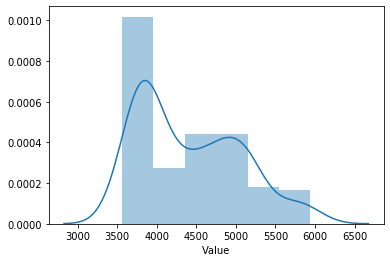

In [26]:
sns.distplot(df['Value'])

In [6]:
df.isnull().sum()

Month    0
Value    0
dtype: int64

In [7]:
df['Month'] = df['Month'].apply(pd.to_datetime)

In [8]:
type(df.Month[0])

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
# Create Date-related Features to be used for EDA
df['year'] = df['Month'].dt.year
df['month'] = df['Month'].dt.month

# Split the series to predict the last 10 months
temp_df = df.set_index('Month')
train_df = temp_df.loc[:'2012-12'].reset_index(drop=False)                         
test_df = temp_df.loc['2013-01':].reset_index(drop=False)

train_df.head()

,Month,Value,year,month
0,2000-01-01,5867,2000,1
1,2000-02-01,5941,2000,2
2,2000-03-01,5907,2000,3
3,2000-04-01,5899,2000,4
4,2000-05-01,5836,2000,5


In [10]:
test_df.head()

,Month,Value,year,month
0,2013-01-01,3890,2013,1
1,2013-02-01,3917,2013,2
2,2013-03-01,3965,2013,3
3,2013-04-01,4012,2013,4
4,2013-05-01,4008,2013,5


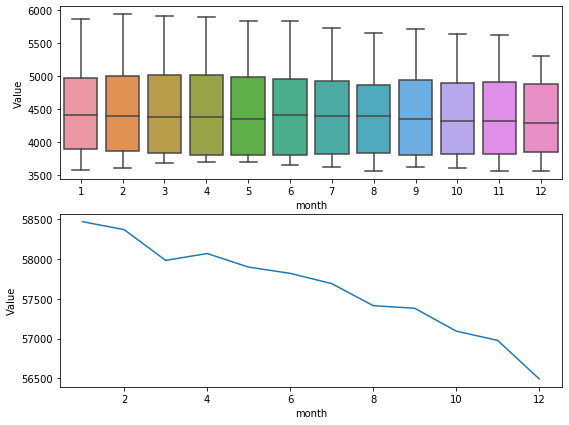

In [11]:
monthly_agg = train_df.groupby('month')['Value'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='month', y='Value', data=train_df, ax=axs[0])
_ = sns.lineplot(x='month', y='Value', data=monthly_agg, ax=axs[1])

Inference: Demands peaked at January and gradually decreased throughout the year and the lowest is on December.

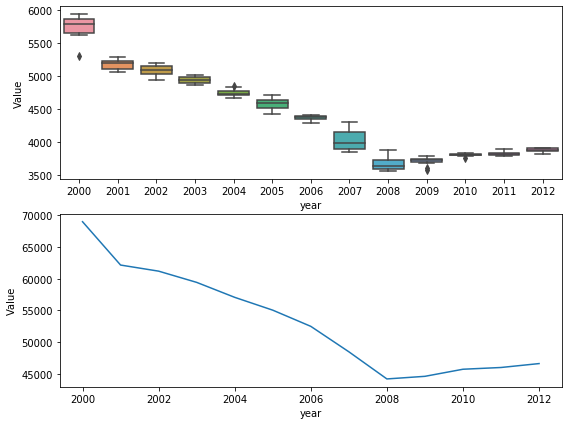

In [12]:
yearly_agg = train_df.groupby('year')['Value'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='year', y='Value', data=train_df, ax=axs[0])
_ = sns.lineplot(x='year', y='Value', data=yearly_agg, ax=axs[1])

Inference: The beverage products demands for this UK based retailer have its highest value on early 2000 and the have gradually decreased trends until reached its bottom point on 2008 (probably due to the economic crisis?) and gradually increased until the end of the time series data.

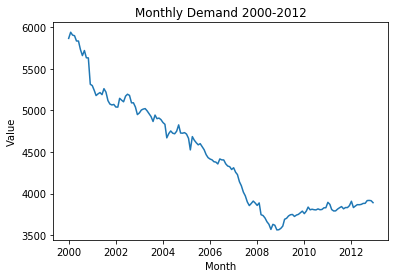

In [13]:
plot = sns.lineplot(x='Month', y='Value', data=train_df)
_ = plot.set(title='Monthly Demand 2000-2012')

#### Build Seasonal ARIMA Model

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting. Seasonal ARIMA is an extension to ARIMA that supports the direct modeling of the seasonal component of the series.

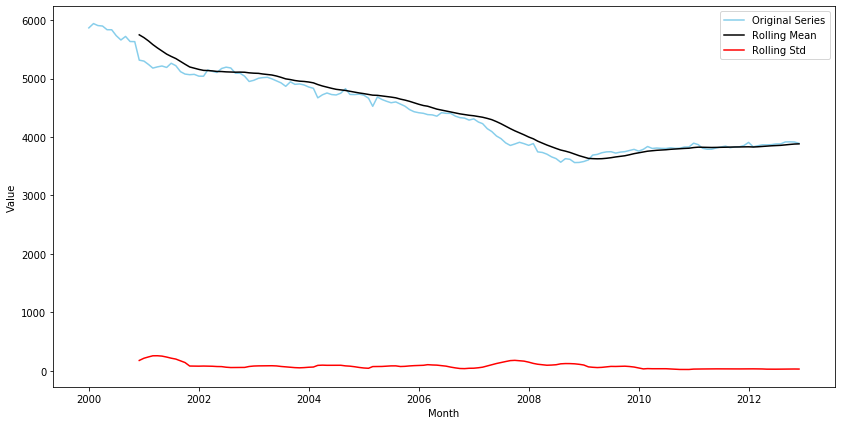

Test statistic = -2.513
P-value = 0.112
Critical values :
	1%: -3.4756368462466662 - The data is not stationary with 99% confidence
	5%: -2.8814104466172608 - The data is not stationary with 95% confidence
	10%: -2.5773652982553568 - The data is not stationary with 90% confidence


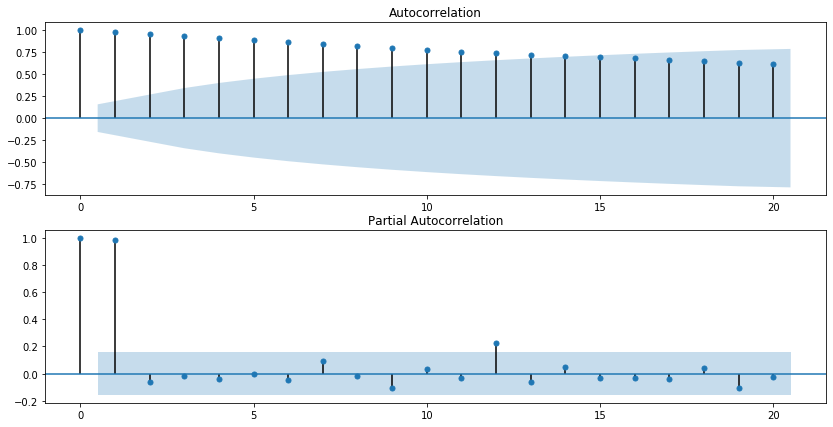

In [27]:
arima_df = train_df[['Month', 'Value']].set_index('Month')
arima_test_df = test_df[['Month', 'Value']].set_index('Month')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=12).mean()
    rollstd = timeseries.rolling(window=12).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.Value)

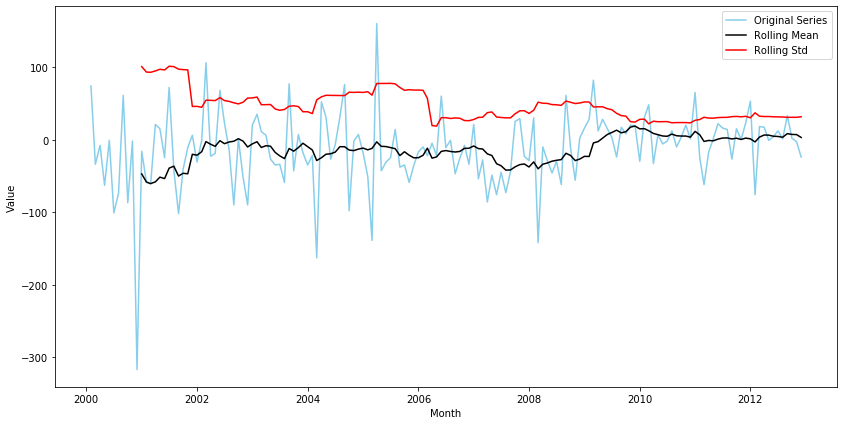

Test statistic = -3.245
P-value = 0.018
Critical values :
	1%: -3.4756368462466662 - The data is not stationary with 99% confidence
	5%: -2.8814104466172608 - The data is  stationary with 95% confidence
	10%: -2.5773652982553568 - The data is  stationary with 90% confidence


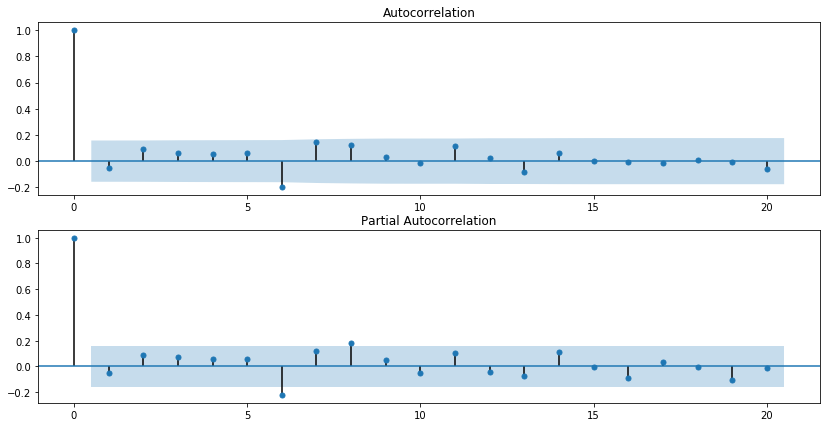

In [17]:
first_difference = arima_df.Value - arima_df.Value.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.Value)

In [18]:
arima_model61 = ARIMA(arima_df.Value, (6,1,1)).fit(disp=False)
print(arima_model61.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  155
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -826.557
Method:                       css-mle   S.D. of innovations             50.023
Date:                Fri, 15 May 2020   AIC                           1671.115
Time:                        12:43:51   BIC                           1698.506
Sample:                    02-01-2000   HQIC                          1682.240
                         - 12-01-2012                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -12.6861      4.322     -2.935      0.004     -21.157      -4.215
ar.L1.D.Value    -0.2491      0.241     -1.035      0.302      -0.721       0.223
ar.L2.D.Value     0.0823      0.082     

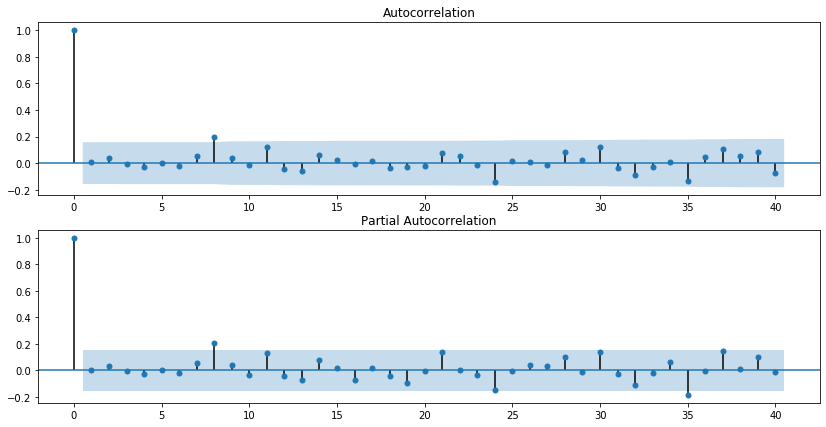

In [19]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

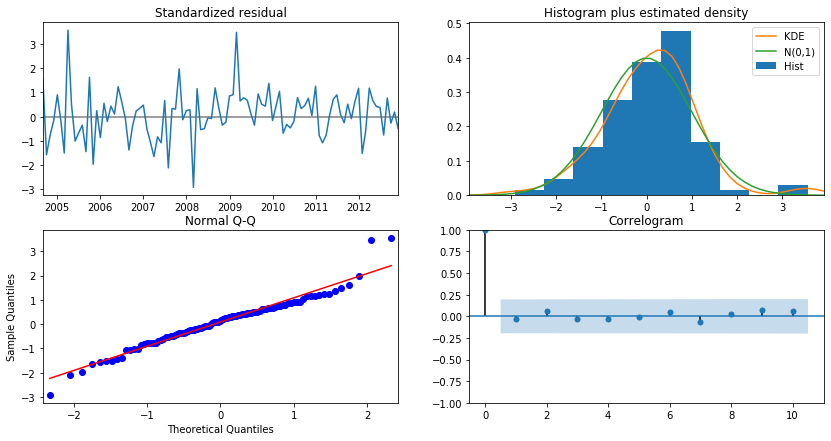

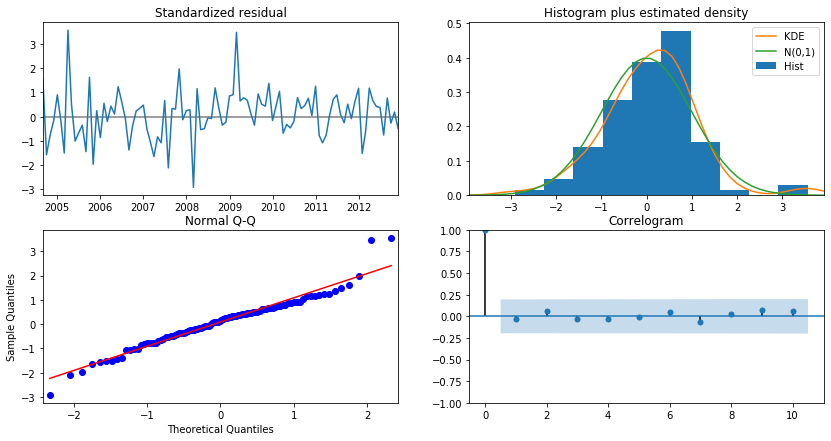

In [20]:
# fit the model
sarima_model = SARIMAX(arima_df.Value, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

#### Evaluation

In order to evaluate the overall forecast, we will look at metrics like mean absolute error (MAE), root mean squared error (RMSE) and mean absolute percentage error (MAPE).

MAE: The average of error after converting all of error value into its absolute value
RMSE: Root value of mean square error
MAPE: Calculated by dividing the sum of absolute errors by sum of actual sales to get a percentage indicator that is scaled to the actual sales. This is the most important metric to evaluate the forecast, the closer to zero mean the better the forecast accuracy.

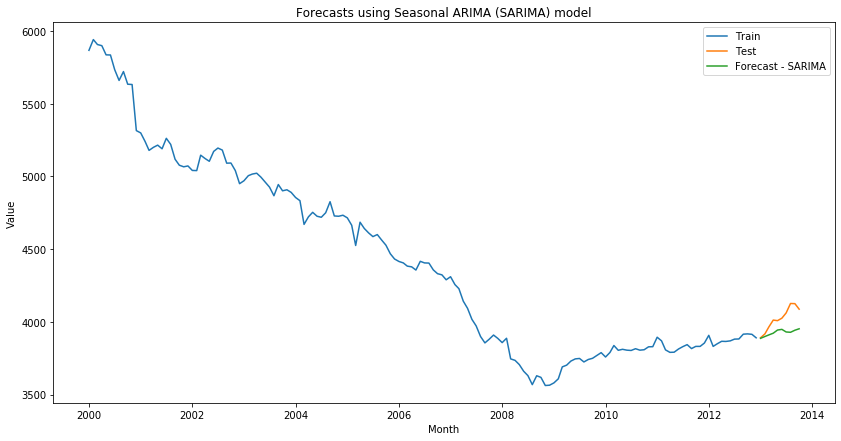

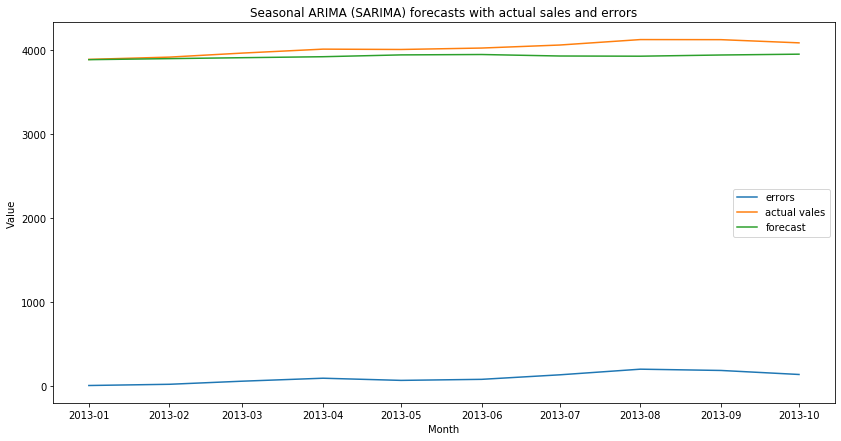

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,40216,39261.088588,954.911412,95.491141,113.825407,2.374456


In [21]:
# Evaluation
arima_test_df['errors'] = arima_test_df.Value - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['Month'], train_df['Value'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['Value'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['Value'], label='actual vales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, Value=errors_df_hw['Value']):
    return np.sum(np.abs(err))/np.sum(Value) * 100

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('Value', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_sarima

#### Conclusion

The model works well resulted in a demand forecast with only 2.37% of means absolute percentage error. Further improvement can be made by adding more features such as macro economic condition.